<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/SelectUsableImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SelectUsableImages is a ONE-TIME notebook that creates a model to select usable images of cats.

Train a VGG16 model pre-trained on the ImageNet set of 14 million images to classify images as either usable or unusable for the feral cat census.  At this time (September 2023), a usable image is one with a single cat.  All other images are deemed unusable.

Sources for the code:
"[Transfer Learning with VGG16 and Keras](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4)" by Gabriel Cassimo

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
input_shape = (224,224, 3) ## Pixel size of images, in each of 3 channels

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = False ## Not trainable weights

58889256/58889256 [==============================] - 0s 0us/step


In [3]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [41]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(128, activation='relu')
dense_layer_2 = layers.Dense(64, activation='relu')
dense_layer_3 = layers.Dense(16, activation='relu')

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
dropout_layer = layers.Dropout(0.5)

# Last layer, remember its binary so we use sigmoid
prediction_layer = layers.Dense(1, activation='sigmoid')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    # dense_layer_2,
    dense_layer_3,
    dropout_layer,
    prediction_layer
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 64)                1605696   
                                                                 
 dense_13 (Dense)            (None, 16)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 16,321,441
Trainable params: 1,606,753
N

In [8]:
## Set up ImageDataGenerator to randomly generate small tweaks to the training images.
## This improves the robustness of the model and increases the size of the
## training data set, which in our case is rather small.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [11]:
## Set up the paths to the training and test data sets.  These are arranged
## to be used by the IDG's flow_from_directory method.

from google.colab import drive
drive.mount('/content/gdrive')
file_path = '/content/gdrive/My Drive/Cat images/ImageDataGenerator_images/'
train_path = file_path + 'train'
test_path = file_path + 'test'


Mounted at /content/gdrive


In [12]:
image_gen.flow_from_directory(train_path)

Found 300 images belonging to 2 classes.


In [13]:
image_gen.flow_from_directory(test_path)

Found 130 images belonging to 2 classes.


In [42]:
## Train the model, using early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [15]:
batch_size = 8
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=input_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 300 images belonging to 2 classes.


In [16]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=input_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 130 images belonging to 2 classes.


In [17]:
train_image_gen.class_indices

{'0': 0, '1': 1}

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
38/38 [==============================] - 9s 188ms/step - loss: 0.7242 - accuracy: 0.6000 - val_loss: 0.7194 - val_accuracy: 0.5000
Epoch 2/20
38/38 [==============================] - 7s 180ms/step - loss: 0.5614 - accuracy: 0.6967 - val_loss: 0.7055 - val_accuracy: 0.4615
Epoch 3/20
38/38 [==============================] - 7s 182ms/step - loss: 0.4777 - accuracy: 0.6800 - val_loss: 0.7378 - val_accuracy: 0.5769
Epoch 4/20
38/38 [==============================] - 6s 159ms/step - loss: 0.4785 - accuracy: 0.7333 - val_loss: 0.7080 - val_accuracy: 0.5231


<Axes: >

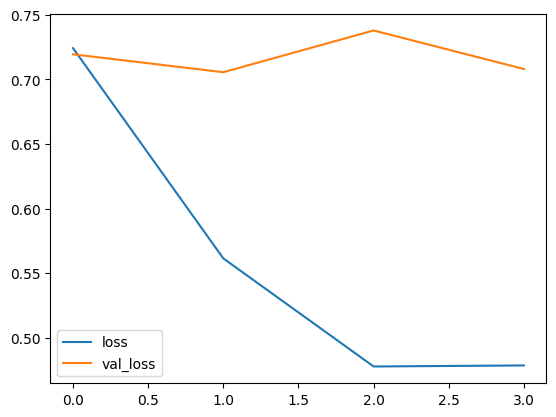

In [44]:
## Evaluate the model
import pandas as pd

losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [21]:
model.metrics_names

['loss', 'accuracy']

In [22]:
model.evaluate_generator(test_image_gen)

[0.6931547522544861, 0.5]

In [45]:
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
pred_probabilities = model.predict_generator(test_image_gen)

In [36]:
pred_probabilities

array([[0.05990257],
       [0.247395  ],
       [0.3533996 ],
       [0.41217473],
       [0.0702587 ],
       [0.0701856 ],
       [0.02475453],
       [0.06754469],
       [0.04975602],
       [0.31450528],
       [0.50565773],
       [0.1079555 ],
       [0.19460325],
       [0.07004804],
       [0.18836977],
       [0.10373468],
       [0.20085362],
       [0.4101658 ],
       [0.26440388],
       [0.02441247],
       [0.02287542],
       [0.06985386],
       [0.10412183],
       [0.05786245],
       [0.40917116],
       [0.03781562],
       [0.0367459 ],
       [0.17119338],
       [0.2238496 ],
       [0.24162146],
       [0.01128547],
       [0.07755368],
       [0.03155418],
       [0.04810744],
       [0.09761908],
       [0.03201063],
       [0.06226147],
       [0.14267895],
       [0.03566704],
       [0.00872139],
       [0.00414567],
       [0.0043764 ],
       [0.0088655 ],
       [0.14285414],
       [0.0191258 ],
       [0.0791278 ],
       [0.01344959],
       [0.097

In [25]:
test_image_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [46]:
predictions = pred_probabilities > 0.5

In [38]:
predictions

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [

In [28]:
from sklearn.metrics import classification_report,confusion_matrix

In [47]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.46      0.55      0.50        65
           1       0.44      0.35      0.39        65

    accuracy                           0.45       130
   macro avg       0.45      0.45      0.45       130
weighted avg       0.45      0.45      0.45       130



In [48]:
confusion_matrix(test_image_gen.classes,predictions)

array([[36, 29],
       [42, 23]])